## Ethereum Stock Prices

* Import data
    * Show prices, market capital and volume
    * Analysis
* Preprocessing data
    * Complete the Index
    * Find NaN and Fix it
    * Closed Price Column
* Split data into training and test datasets
    * Normalizing
* Build the model
* Test the model
* Conclusions

### Import Libraries

In [1]:
import random
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

### Import Data and Analysis

In [2]:
data = pd.read_csv('eth-eur.csv')
data.iloc[random.randint(0, data.shape[0])]

snapped_at      2015-11-01 00:00:00 UTC
price                          0.961015
market_cap                  7.14879e+07
total_volume                     548348
Name: 85, dtype: object

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 4 columns):
snapped_at      896 non-null object
price           896 non-null float64
market_cap      895 non-null float64
total_volume    896 non-null float64
dtypes: float64(3), object(1)
memory usage: 28.1+ KB


In [4]:
#customize index
data.snapped_at[0].split()[0]
data.snapped_at = data.snapped_at.apply(lambda x: x.split()[0])

In [5]:
data.set_index('snapped_at', inplace=True)
data.index = pd.to_datetime(data.index)

In [6]:
features = ['price', 'market_cap', 'total_volume']

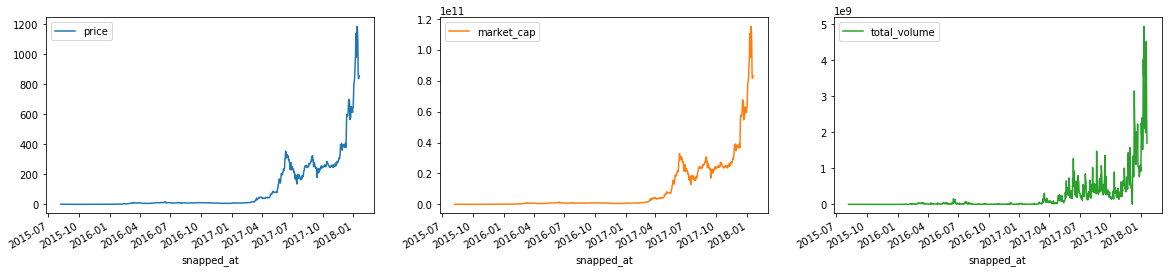

In [7]:
data[features].plot(subplots=True, layout=(1,3), figsize=(20,4));

In [8]:
data.iloc[0:10]

,price,market_cap,total_volume
snapped_at,,,
2015-08-07,2.580213,0.000000e+00,8.257608e+04
2015-08-08,1.175306,7.095505e+07,3.250759e+05
2015-08-10,0.624116,3.772033e+07,3.634980e+05
2015-08-11,0.966607,5.844581e+07,1.375588e+06
2015-08-12,1.126292,6.813006e+07,1.858814e+06
2015-08-13,1.636673,9.904778e+07,3.927292e+06
2015-08-14,1.643557,9.951063e+07,3.920484e+06
2015-08-15,1.505036,9.116528e+07,2.269451e+06
2015-08-16,1.329391,8.055977e+07,2.730304e+06


### Preprocessing Data

#### Complete the Index

The list is not complete _(2015-08-09 is missing)_ so we have to fill the blanks.

In [9]:
#check
'2015-08-09 00:00:00' in data.index

False

In [10]:
#Generate all the possible days and use them to reindex
start = data.index[data.index.argmin()]
end = data.index[data.index.argmax()]

index_complete = pd.date_range(start, end)
data = data.reindex(index_complete)

#### Find NaN and Fix it

In [11]:
#Fill the blanks with the mean between the previous and the day after

for idx in data.index:
    dayloc = data.index.get_loc(idx)
    day = data.loc[idx]
    if day.hasnans:
        #updating
        rg = slice(dayloc-1, dayloc+2)
        data.loc[idx] = data.iloc[rg].mean()
        
        print("Day <{}> updated".format(idx))

Day <2015-08-09 00:00:00> updated
Day <2017-04-02 00:00:00> updated


In [12]:
#check
data.loc['2015-08-09 00:00:00']

price           8.997108e-01
market_cap      5.433769e+07
total_volume    3.442869e+05
Name: 2015-08-09 00:00:00, dtype: float64

In [13]:
#Checking if we have NaN in another place
data[data.isnull().any(axis=1)].count()

price           0
market_cap      0
total_volume    0
dtype: int64

#### Closed Price Column

In [14]:
new_column = 'closed_price'
datab = data.copy()

nc = list()

for idx in data.index:
    dayloc = data.index.get_loc(idx)
    
    #we put the price in the day after as closed price
    if dayloc == len(data.index)-1:
        #last position will not have closed_price
        closed_price = np.nan
    else:
        closed_price = data.iloc[dayloc+1].price
    
    nc.append(closed_price)

data[new_column] = nc
data.tail(5)

,price,market_cap,total_volume,closed_price
2018-01-15,1084.204749,1.051702e+11,1.988101e+09,871.038635
2018-01-16,871.038635,8.450991e+10,4.236883e+09,838.829188
2018-01-17,838.829188,8.140486e+10,4.516756e+09,846.823344
2018-01-18,846.823344,8.219815e+10,2.632209e+09,856.639434
2018-01-19,856.639434,8.316864e+10,1.691466e+09,NaN


In [15]:
#Delete last because we don't know still the closed price 
data = data.drop(data.index[len(data)-1])

In [16]:
def prepare_sequence(data):
    sequence = []
    sequence_size = 7
    samples = 0
    for i in range(0, data.shape[0] - sequence_size + 1):
        sequence.append(data[i:i+7])
        samples += 1
    return np.concatenate(sequence).reshape((samples, sequence_size, data.shape[1]))

prepare_sequence(data[features]).shape

(890, 7, 3)

### Split Data into Training and Test Datasets

In [17]:
#X_train, X_test, y_train, y_test = train_test_split(data[features], 
#                                                    data.closed_price, 
#                                                    test_size=0.20,
#                                                    shuffle=False,
#                                                    random_state=42)

#80% for training
split = round(len(data)*0.8)
data_train, data_test = data[:split].copy(), data[split:].copy()

In [18]:
print("Size data_train: {}".format(data_train.shape[0]))
print("Size data_test: {}".format(data_test.shape[0]))

Size data_train: 717
Size data_test: 179


#### Normalizing

Take care of this because we __don't know if the future values are in the range__. For this reason we __fit the scaler using training data__ nor the testing.

In [19]:
#Scale the data
scaler = MinMaxScaler()

data_train[data.columns] = scaler.fit_transform(data_train[data.columns])
data_test[data.columns] = scaler.transform(data_test[data.columns])

data_test.describe()

,price,market_cap,total_volume,closed_price
count,179.000000,179.000000,179.000000,179.000000
mean,1.060961,1.099274,0.639154,1.071383
std,0.648539,0.684319,0.677951,0.655108
min,0.459819,0.466341,0.003886,0.459819
25%,0.705858,0.719985,0.241367,0.706117
50%,0.753022,0.774184,0.371323,0.756387
75%,1.113458,1.157047,0.732712,1.117402
max,3.336560,3.497460,3.885077,3.336560


## Check Tensorflow and GPU

In [20]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/samuel/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: No GPU found. Please use a GPU to train your neural network.
  # This is added back by InteractiveShellApp.init_path()


## Build the Model
### Regressor model

* 1 step and 3 features

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten

X_train = data_train[features].values.reshape((data_train.shape[0], 1, 3))
y_train = data_train.closed_price.values

X_test = data_test[features].values.reshape((data_test.shape[0], 1, 3))
y_test = data_test.closed_price.values


Using TensorFlow backend.


In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(717, 1, 3)
(717,)
(179, 1, 3)
(179,)


In [23]:
model = Sequential()
model.add(LSTM(32, input_shape=(1, 3) ))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

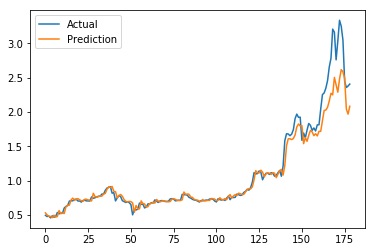

In [24]:
pred = model.predict(X_test)
plt.plot(y_test, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()

### Sequence model

* 7 steps and 3 features

In [25]:
#getting (samples, steps, features)
X_train = prepare_sequence(data_train[features])
X_test = prepare_sequence(data_test[features])

#closed price to predict will be the last price of the last step in sequence
#for this reason the closed price of sequence [0:7] will be [6]
y_train = data_train.iloc[-len(X_train):].closed_price.values
y_test = data_test.iloc[-len(X_test):].closed_price.values

In [26]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(711, 7, 3)
(711,)
(173, 7, 3)
(173,)


In [27]:
model = Sequential()
model.add(LSTM(32, input_shape=(7, 3) ))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

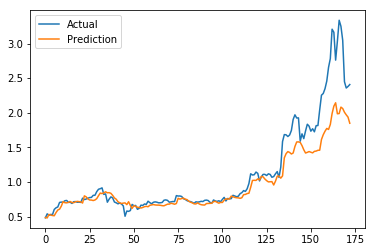

In [28]:
pred = model.predict(X_test)
plt.plot(y_test, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()

----

### ⇩ __NORMALIZE A WINDOW OF STEPS BY THE RATE OF CHANGE__ ⇩
The neural network is not able to get good predictions for that data that has not seen before. For that reason we find the last fifty days are not well fitted. This problem is related to the 'out-of-scale' data inputs.

Thinking that the batch size is a window of days that defines how the neural network learns, one idea is to normalize the window by the last sample. On this way we'll be able to keep almost all data in the same scale.

In [35]:
def print_mean_std(data):
    mean = np.mean(data)
    std = np.std(data)
    print("mean:{:.3f} std:{:.3f}".format(mean, std))

In [57]:
def window_normalization(data, window_size):
    y = np.empty_like(data, dtype='float64')
    for i in range(0,len(data), window_size):
        j = min(i+window_size, len(data))
        y[i:j] = data[i:j]/np.abs(data[j-1])
        print_mean_std(y[i:j])
        
    return y

In [58]:
#testing the function
a = np.array([[1, 1, 1], [2, 2, 2], [2, 2, 2], [8, 8, 8]])
expected_result = np.array([[0.5, 0.5, 0.5], [1, 1, 1], [0.25, 0.25, 0.25], [1, 1, 1]])
assert ( np.array_equal(window_normalization(a, 2), expected_result) )

mean:0.750 std:0.250
mean:0.625 std:0.375


In [59]:
window_size=32

X_train = data_train[features].values
y_train = data_train.closed_price.values

X_train = window_normalization(X_train, window_size)
y_train = window_normalization(y_train, window_size)

#getting (samples, steps, features)
X_train = prepare_sequence(X_train)
y_train = y_train[-len(X_train):]

mean:1.697 std:1.866
mean:1.589 std:0.886
mean:0.831 std:0.673
mean:0.741 std:0.281
mean:0.679 std:0.355
mean:0.547 std:0.441
mean:0.717 std:0.331
mean:1.072 std:0.328
mean:0.600 std:0.230
mean:0.885 std:0.415
mean:0.668 std:0.323
mean:2.864 std:4.536
mean:1.280 std:1.032
mean:0.935 std:0.265
mean:1.289 std:0.613
mean:1.079 std:0.750
mean:1.043 std:0.531
mean:0.756 std:0.539
mean:0.958 std:0.597
mean:0.734 std:0.451
mean:0.961 std:0.801
mean:1.372 std:0.473
mean:1.419 std:0.978
mean:1.075 std:0.264
mean:1.938 std:0.816
mean:0.876 std:0.586
mean:0.921 std:0.113
mean:0.725 std:0.116
mean:0.479 std:0.272
mean:0.796 std:0.310
mean:1.193 std:0.165
mean:0.679 std:0.144
mean:1.113 std:0.173
mean:0.932 std:0.103
mean:1.016 std:0.096
mean:0.948 std:0.067
mean:1.063 std:0.047
mean:1.226 std:0.076
mean:0.976 std:0.057
mean:0.958 std:0.059
mean:0.689 std:0.141
mean:0.890 std:0.273
mean:0.696 std:0.193
mean:0.598 std:0.230
mean:1.599 std:0.280
mean:0.929 std:0.097


In [60]:
model = Sequential()
model.add(LSTM(32, input_shape=(7,3) ))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=window_size, verbose=0)

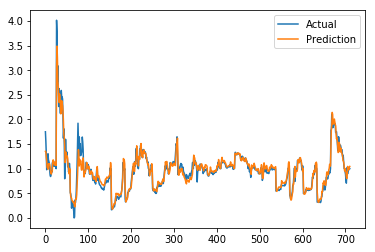

In [61]:
pred = model.predict(X_train)
plt.plot(y_train, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()

mean:0.982 std:0.521
mean:1.256 std:0.569
mean:1.313 std:0.736
mean:0.825 std:0.340
mean:0.943 std:0.400
mean:1.062 std:0.295
mean:0.823 std:0.138
mean:1.058 std:0.149
mean:1.013 std:0.043
mean:0.826 std:0.139
mean:0.834 std:0.179
mean:1.094 std:0.178


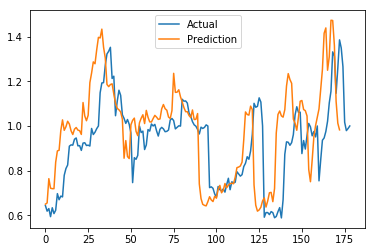

In [62]:
X_test = data_test[features].values
y_test = data_test.closed_price.values

X_test = window_normalization(X_test, window_size)
y_test = window_normalization(y_test, window_size)

#getting (samples, steps, features)
X_test = prepare_sequence(X_test)
y_test = y_test[-len(X_train):]

pred = model.predict(X_test)
plt.plot(y_test, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()

## LOG

1. Added new method 'print_mean_std' to detect the stability of the data within the window size.
    * Would it affect the formula is being used for window normalization?